In [1]:
# import numpy and exp mat
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import loguniform

from module.QuantumSystem import SHOscillator
from module.Walker import FokkerPlankWalker
from module.Utils import VMC, Analizer

np.random.seed(0)

# Spherical Harmonic Oscillator without interaction, with Metropolis and analytical hamiltonian
In this notebook we study the warmup phase of FokkerPlank algoritm starting with a configuration in phase space "distant" from the steady state, in particular 
$$ X_0 \sim N(0,1) + 5 $$
And we look  at the local energy as a function of the MC steps for different hyperparameter of the sampler, the step size $\texttt{delta}$ and the number of particle moved for step $\texttt{subgroup\_size}$. 

## Warmup as a function of $\texttt{delta}$ and $\texttt{subgroup\_size}$
We sample randomly 100 couple of value for:
$$ \texttt{delta} \sim LogUnif(10^{-5}, 1) $$
$$ \texttt{subgroup\_size} \sim Unif(1, \texttt{system.N}) $$
Then we study the local energies as function of MC step. We complare the result with a walker  with hyperparameter chosen with our calibration alghortim that aim for an acceptance ratio of 0.57 for just 1/10 of the total step.

-----------------
VMC calibrate
-----------------
delta: 0.0052819551427343864
subgroup_size: 1
Acceptance rate: 0.59
-----------------
VMC warmup
-----------------
Parameters: [0.6]
Acceptance rate: 0.75438


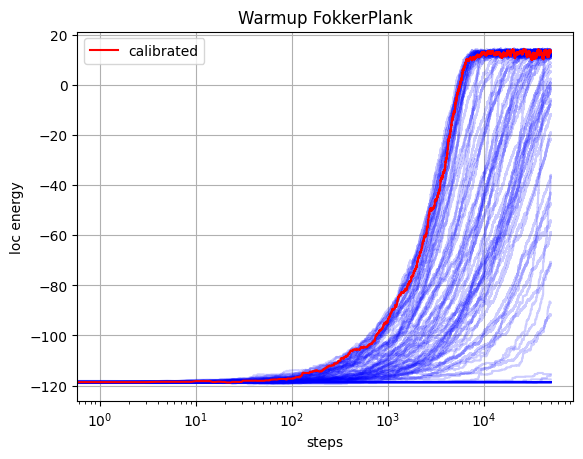

In [3]:
params = np.array([0.6])
warmup_steps = 50000


N = 5
D = 5
system = SHOscillator(N, D, params)


# let X_0 ~ N(0, 100)
X_0 = np.random.normal(0, 1, (N, D)) + 5
chain = np.zeros((warmup_steps, N, D))
energies = np.zeros(warmup_steps)

plt.figure()
for i in range(100):
    # sampling hyperparameter
    delta = loguniform.rvs(1e-5, 1e0)
    subgroup_size = np.random.randint(1, N+1)

    # getting the chain
    walker = FokkerPlankWalker(system, X=X_0, delta=delta, subgroup_size=subgroup_size)
    chain = walker.get_chain(warmup_steps)
    analizer = Analizer(system, chain)
    energies = analizer.get_local_energies()
    plt.plot(energies, color="b", alpha=0.2)

# compare with calibrated hyperparameter
vmc = VMC(system=system, walker=walker, params=params,
          calibrate_steps=10000, batch_steps=100, acceptance_rate=0.57,
          warmup_steps=50000, verbose=True)
# calibrate
vmc.walker.X = X_0
vmc.calibrate()

# start again with a position "far away" from steady
vmc.walker.X = X_0
vmc.warmup()
chain = vmc.warmup_chain
analizer = Analizer(system, chain)
energies = analizer.get_local_energies()
plt.plot(energies, label="calibrated", color="r")

plt.xscale("log")   
plt.xlabel("steps")
plt.ylabel("loc energy")
plt.legend()
plt.grid()
plt.title("Warmup FokkerPlank")
plt.savefig("results/warmup_fokkerplank.png")